# Polars introduction


This notebook is loosely based on:

- ["A Practical Introduction to Polars for Python Data Processing" P. Darugar](https://www.parand.com/a-practical-introduction-to-polars.html)
- ["Modern Polars" K. Heavey](https://kevinheavey.github.io/modern-polars/)
- [Polars user guide](https://pola-rs.github.io/polars-book/user-guide/)
- [Polars blog - A bird's eye view of Polars](https://pola.rs/posts/polars_birds_eye_view/)


## Downloading data


We will use [New York City yellow taxi trips](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) from 2024. This is a typical raw input to ML pipelines, with individual events as rows. We will download full 2024 data. Due to its size, it's already distributed as Parquet files. Feature descriptions are available [as a data dictionary document](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).


In [65]:
import os
import subprocess

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)


for month in range(1, 13):
    if not os.path.exists(f"{DATA_DIR}/{month}.parquet"):
        subprocess.run(
            [
                "wget",
                f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-{month:02}.parquet",
                "-O",
                f"{DATA_DIR}/{month}.parquet",
            ]
        )


total_size = sum(
    os.path.getsize(f"{DATA_DIR}/{month}.parquet") for month in range(1, 13)
)  # bytes
total_size_mb = total_size // (1024 * 1024)
print(f"Total dataset size: {total_size_mb} MB")

Total dataset size: 660 MB


For later queries, we will also download mapping for location IDs.


In [66]:
if not os.path.exists(f"{DATA_DIR}/taxi_zone_lookup.csv"):
    subprocess.run(
        [
            "wget",
            "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv",
            "-O",
            f"{DATA_DIR}/taxi_zone_lookup.csv",
        ]
    )

## DataFrames, selecting and filtering


Polars works generally very similarly to Pandas. We will use mostly eager evaluation here. If you run into memory problems, use only later month, e.g. 6-12.


In [67]:
import polars as pl

df = pl.read_parquet(f"{DATA_DIR}/1.parquet")
df

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-01-31 23:45:59,2024-01-31 23:54:36,null,3.18,null,null,107,263,0,15.77,0.0,0.5,2.0,0.0,1.0,21.77,null,null
1,2024-01-31 23:13:07,2024-01-31 23:27:52,null,4.0,null,null,114,236,0,18.4,1.0,0.5,2.34,0.0,1.0,25.74,null,null
2,2024-01-31 23:19:00,2024-01-31 23:38:00,null,3.33,null,null,211,25,0,19.97,0.0,0.5,0.0,0.0,1.0,23.97,null,null


In [68]:
type(df)

polars.dataframe.frame.DataFrame

Checking columns, data types, and shape is also similar to Pandas.


In [69]:
# Python list of strings
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [70]:
# Python list of data types from pd.datatypes
df.dtypes

[Int32,
 Datetime(time_unit='ns', time_zone=None),
 Datetime(time_unit='ns', time_zone=None),
 Int64,
 Float64,
 Int64,
 String,
 Int32,
 Int32,
 Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64]

In [71]:
# tuple of integers
df.shape

(2964624, 19)

A few basics:

- **selecting** columns is done with `.select()`
- **filtering** rows is done with `.filter()`
- **columns** are used either as strings for simple uses, or as objects created with `pl.col(col_name)` for more complex transformations
- **expressions** are lazily evaluated objects (always, even in eager mode), representing data transformations
- **methods** are typically run on expressions, e.g. `.is_null()`

Selecting and filtering operations take columns or expressions. A single column is also an expression. Let's see a few examples.


In [72]:
df.select("passenger_count")

passenger_count
i64
1
1
1
1
1
…
null
null
null


In [73]:
df.select(pl.col("passenger_count"))

passenger_count
i64
1
1
1
1
1
…
null
null
null


In [74]:
df.filter(pl.col("passenger_count").is_not_null())

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-01-31 23:10:28,2024-01-31 23:18:30,1,3.51,1,"""N""",138,129,1,16.3,6.0,0.5,4.76,0.0,1.0,30.31,0.0,1.75
2,2024-01-31 23:01:04,2024-01-31 23:17:35,1,3.36,1,"""N""",162,261,1,18.4,1.0,0.5,5.85,0.0,1.0,29.25,2.5,0.0
1,2024-01-31 23:08:13,2024-01-31 23:25:00,3,3.3,1,"""N""",43,249,1,17.7,3.5,0.5,1.0,0.0,1.0,23.7,2.5,0.0


Filters can be combined with `&` (AND) and `|` (OR), or negated with `~`, like in Pandas. For AND, you can also pass filters as a list.


In [75]:
df.filter(pl.col("passenger_count").is_not_null(), pl.col("tip_amount") < 1.0)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.0,1,"""N""",246,231,2,25.4,3.5,0.5,0.0,0.0,1.0,30.4,2.5,0.0
2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,"""N""",161,261,2,31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0
2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,"""N""",113,113,2,3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0
2,2024-01-01 00:35:22,2024-01-01 00:41:41,2,0.75,1,"""N""",107,137,1,7.9,1.0,0.5,0.0,0.0,1.0,12.9,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2024-01-31 23:44:29,2024-01-31 23:56:23,2,1.3,1,"""N""",68,246,2,10.0,3.5,0.5,0.0,0.0,1.0,15.0,2.5,0.0
1,2024-01-31 23:31:32,2024-01-31 23:40:41,1,1.6,1,"""Y""",234,48,1,10.7,3.5,0.5,0.0,0.0,1.0,15.7,2.5,0.0
2,2024-01-31 23:25:48,2024-01-31 23:25:55,1,0.0,2,"""N""",50,50,2,70.0,0.0,0.5,0.0,0.0,1.0,74.0,2.5,0.0


In [76]:
# alternative syntax with &
df.filter((pl.col("passenger_count").is_not_null()) & (pl.col("tip_amount") < 1.0))

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.0,1,"""N""",246,231,2,25.4,3.5,0.5,0.0,0.0,1.0,30.4,2.5,0.0
2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,"""N""",161,261,2,31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0
2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,"""N""",113,113,2,3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0
2,2024-01-01 00:35:22,2024-01-01 00:41:41,2,0.75,1,"""N""",107,137,1,7.9,1.0,0.5,0.0,0.0,1.0,12.9,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2024-01-31 23:44:29,2024-01-31 23:56:23,2,1.3,1,"""N""",68,246,2,10.0,3.5,0.5,0.0,0.0,1.0,15.0,2.5,0.0
1,2024-01-31 23:31:32,2024-01-31 23:40:41,1,1.6,1,"""Y""",234,48,1,10.7,3.5,0.5,0.0,0.0,1.0,15.7,2.5,0.0
2,2024-01-31 23:25:48,2024-01-31 23:25:55,1,0.0,2,"""N""",50,50,2,70.0,0.0,0.5,0.0,0.0,1.0,74.0,2.5,0.0


In [77]:
df.filter((pl.col("passenger_count").is_not_null()) | (pl.col("tip_amount") < 1.0))

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2024-01-31 23:33:12,2024-01-31 23:48:42,null,2.6,null,null,161,249,0,15.01,0.0,0.5,0.0,0.0,1.0,19.01,null,null
1,2024-01-31 23:22:09,2024-01-31 23:33:41,null,2.3,null,null,211,170,0,12.1,1.0,0.5,0.0,0.0,1.0,17.1,null,null
2,2024-01-31 23:46:39,2024-01-31 23:57:31,null,3.27,null,null,161,24,0,15.73,0.0,0.5,0.0,0.0,1.0,19.73,null,null


In [78]:
# similarly for selecting many columns, you can also use strings directly
df.select(["tpep_pickup_datetime", "tpep_dropoff_datetime"])

tpep_pickup_datetime,tpep_dropoff_datetime
datetime[ns],datetime[ns]
2024-01-01 00:57:55,2024-01-01 01:17:43
2024-01-01 00:03:00,2024-01-01 00:09:36
2024-01-01 00:17:06,2024-01-01 00:35:01
2024-01-01 00:36:38,2024-01-01 00:44:56
2024-01-01 00:46:51,2024-01-01 00:52:57
…,…
2024-01-31 23:45:59,2024-01-31 23:54:36
2024-01-31 23:13:07,2024-01-31 23:27:52
2024-01-31 23:19:00,2024-01-31 23:38:00


There is also a shortcut syntax for selecting columns with `[]`, like in Pandas. It's quite limited though, you can also read the data this way, and not e.g. create new columns or assign values. However, it's useful for simple analytics.


In [79]:
df["tip_amount"].mean()

3.3358700158940913

In [80]:
# .mean(), .sum() etc. ignore NULL values by default, like in Pandas
df["passenger_count"].sum()

3782748

In [81]:
# you can combine both syntax styles
df.filter(pl.col("Airport_fee") == 0)["total_amount"].median()

19.15

To create new columns or overwrite values of existing ones, use `.with_columns()`. You can rename them either by using a keyword argument, or by using `.alias()`. You can also rename columns with `.rename()`. If you don't need any old column, just create a value and use it further, you can just use `.select()` and create column inside.

For chaining many operations, it's very useful to wrap the entire pipelines in parentheses `()`. This is a proper multiline Python syntax for making many method calls one after another, and a great pattern overall. It avoids making ugly backslash `\` after every line.


In [82]:
# set strict=False so you can run this cell twice without errors
df = df.rename({"Airport_fee": "airport_fee"}, strict=False)
df

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-01-31 23:45:59,2024-01-31 23:54:36,null,3.18,null,null,107,263,0,15.77,0.0,0.5,2.0,0.0,1.0,21.77,null,null
1,2024-01-31 23:13:07,2024-01-31 23:27:52,null,4.0,null,null,114,236,0,18.4,1.0,0.5,2.34,0.0,1.0,25.74,null,null
2,2024-01-31 23:19:00,2024-01-31 23:38:00,null,3.33,null,null,211,25,0,19.97,0.0,0.5,0.0,0.0,1.0,23.97,null,null


In [83]:
# what is the average trip time?
(
    df.with_columns(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).alias(
            "trip_time"
        )
    )
    .select("trip_time")
    .mean()
)

trip_time
duration[ns]
15m 36s 777037155ns


In [84]:
# another way of aliasing columns are keyword arguments
(
    df.with_columns(
        trip_time=(pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
    )
    .select("trip_time")
    .mean()
)

trip_time
duration[ns]
15m 36s 777037155ns


In [85]:
# you can build any pipelines, data filtering etc. this way
(
    df.filter(pl.col("passenger_count").is_not_null(), pl.col("tip_amount") < 1.0)
    .select(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).alias(
            "trip_time"
        )
    )
    .median()
)

trip_time
duration[ns]
11m 19s


Since Polars expressions are objects, they can be created beforehand. They are executed lazily, only when you call appropriate methods on the actual DataFrame. This is very useful for building more complex pipelines, as it helps avoid code repetition with common operations and increases readability with variable names. You can also write regular Python functions, objects, and tests working on Polars expressions.


In [86]:
# same pipeline as above, but with pre-built expressions
trip_time = (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).alias(
    "trip_time"
)
non_tipping_passengers = pl.col("passenger_count").is_not_null() & (
    pl.col("tip_amount") < 1.0
)

(df.filter(non_tipping_passengers).select(trip_time).median())

trip_time
duration[ns]
11m 19s


Results of Polars data processing can be easily transformed to Pandas DataFrame for integration with frameworks that don't support Polars directly. This uses `.to_pandas()` method.


In [87]:
df_passengers = (
    df.filter(pl.col("passenger_count").is_not_null())
    .select("passenger_count")
    .to_pandas()
)
df_passengers

,passenger_count
0,1
1,1
2,1
3,1
4,1
...,...
2824457,1
2824458,1
2824459,3
2824460,0


**Exercises**

1. How many passengers paid by card, and how many by cash? Check [the data dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) and `payment_type` meaning.
2. What percentage of passengers paying by card gave any tip?
3. What percentage of passengers had to pay any additional charge (`extra`, `tolls_amount`, `congestion_surcharge`, or `airport_fee`)?
4. Plot a histogram of trip times with a single passenger. Exclude any trips over 120 minutes. Use [temporal .dt attributes](https://docs.pola.rs/api/python/stable/reference/expressions/temporal.html).
5. What is the Pearson correlation between trip time (in minutes) and trip length?


1. 439191 passengers paid by cash and 2319046 by card.


In [88]:
(df.filter(pl.col("payment_type").is_in([1, 2])).group_by("payment_type").len())

payment_type,len
i64,u32
2,439191
1,2319046


2. 0.03% of passengers paying by card gave any tip.


In [89]:
pct_card_passengers_tipped = (
    df.filter(pl.col("payment_type") == 2)
    .select((pl.col("tip_amount") > 0).mean() * 100)
    .item()
)
print(
    f"Percentage of passengers who paid by card and left a tip: {pct_card_passengers_tipped:.2f}%"
)

Percentage of passengers who paid by card and left a tip: 0.03%


3. Percentage of passengers that paid extra charge: 96.39%


In [90]:
pct_extra_charge = (
    df.select(
        (pl.col("airport_fee") > 0)
        | (pl.col("congestion_surcharge") > 0)
        | (pl.col("tolls_amount") > 0)
        | (pl.col("extra") > 0)
    ).mean()
    * 100
).item()
print(f"Percentage of passengers that paid extra charge: {pct_extra_charge:.2f}%")

Percentage of passengers that paid extra charge: 96.39%


4. Histogram of trip times with a single passenger (excluding trips over 120 minutes)


In [91]:
durations = df.with_columns(
    (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
    .dt.total_minutes()
    .alias("duration")
).filter((pl.col("passenger_count") == 1) & (pl.col("duration") < 120))

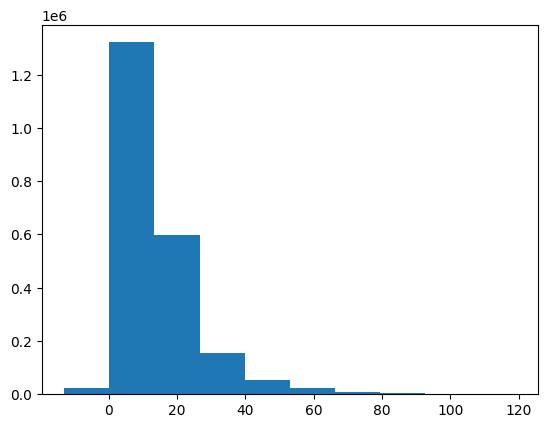

In [92]:
import matplotlib.pyplot as plt

plt.hist(durations["duration"])
plt.show()

5. Pearson correlation between trip time (in minutes) and trip length


In [93]:
correlation = (
    df.with_columns(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
        .dt.total_minutes()
        .alias("trip_time")
    )
    .select(pl.corr("trip_time", "trip_distance"))
    .item()
)

print(f"Correlation: {correlation:.4f}")

Correlation: 0.0054


## Joining and aggregations


Polars also supports other typical SQL operations for analytics:

- joining DataFrames with `.join()` method
- GROUP BY with `.group_by()`
- windowing functions for time aggregations with `.group_by_dynamic()`
- sorting data with `.sort()`

Making an alias to explicitly name a column after grouping is very useful.

As an example of grouping, we will calculate the average cost of trips starting in each location (PU - pickup location, DO - dropoff location).


In [94]:
df_pu_location_means = df.group_by(["PULocationID"]).agg(
    pl.col("total_amount").mean().alias("average_cost")
)
df_pu_location_means

PULocationID,average_cost
i32,f64
3,43.638857
161,23.482411
18,40.589519
155,39.013053
21,35.823103
…,…
101,38.352679
128,42.432273
241,37.85189


Those IDs aren't very informative. However, we can join them with information from `taxi_zone_lookup.csv`, to get a clearer picture.


In [95]:
df_taxi_zones = pl.read_csv("data/taxi_zone_lookup.csv")
df_taxi_zones

LocationID,Borough,Zone,service_zone
i64,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""
…,…,…,…
261,"""Manhattan""","""World Trade Center""","""Yellow Zone"""
262,"""Manhattan""","""Yorkville East""","""Yellow Zone"""
263,"""Manhattan""","""Yorkville West""","""Yellow Zone"""


In [96]:
(
    df_pu_location_means.join(
        df_taxi_zones, left_on="PULocationID", right_on="LocationID"
    )
    .select(["Borough", "Zone", "average_cost"])
    .sort("average_cost", descending=True)
)

Borough,Zone,average_cost
str,str,f64
"""Staten Island""","""Charleston/Tottenville""",354.23
"""Staten Island""","""Port Richmond""",121.51
"""Staten Island""","""Great Kills""",111.48
"""Staten Island""","""Heartland Village/Todt Hill""",105.842222
"""EWR""","""Newark Airport""",104.196712
…,…,…
"""Queens""","""Saint Michaels Cemetery/Woodsi…",13.256995
"""Queens""","""Queensbridge/Ravenswood""",10.274222
"""Bronx""","""Rikers Island""",10.2


Grouping this way is perfect for analyzing different data segments, such as regions or customer types. However, for analyzing groups changing in time, SQL and DataFrame framework use a concept of windows and window functions. They are basically groups, but dynamic in time. Those calculations are very common in analytics, but also very computationally intensive.

As an example, we will compute the average daily travel time in different days. Note that in Polars, window functions need a sorted input column.


<Axes: xlabel='tpep_dropoff_datetime'>

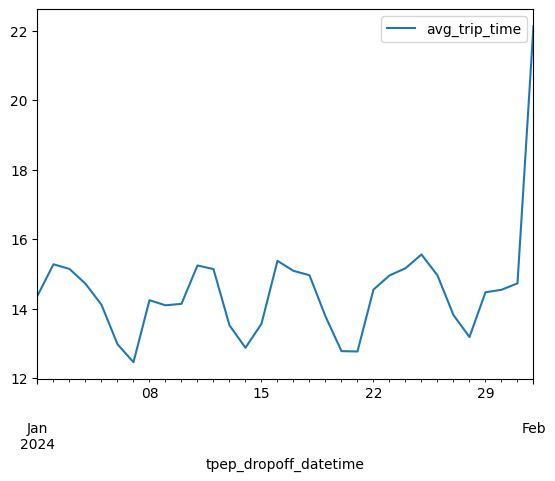

In [97]:
df_daily_avg_trip_times = (
    df.with_columns(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
        .dt.total_minutes()
        .alias("trip_time")
    )
    # we have some errors in the data, we'll clean them in the next section
    .filter(pl.col("trip_time") < 120)
    .filter(pl.col("tpep_dropoff_datetime").dt.year() == 2024)
    .sort("tpep_dropoff_datetime")
    .group_by_dynamic("tpep_dropoff_datetime", every="1d")
    .agg(pl.col("trip_time").mean().alias("avg_trip_time"))
    .to_pandas()
    .plot.line(x="tpep_dropoff_datetime", y="avg_trip_time")
)
df_daily_avg_trip_times

**Exercises**

1. What is the mean distance of trips with different number of passengers? Plot them on a bar plot. Exclude null values.
2. What is the median total trip cost (`total_amount`) during the day, and during the night? Assume that day hours are 6:30-19:30. [pl.time](https://docs.pola.rs/api/python/dev/reference/expressions/api/polars.time.html) may be useful.
3. What are the top 5 pairs of boroughs with the highest average trip time?
4. Calculate average costs of trip per minute, if starts and ends in the same borough and zone. What are the names of 5 boroughs and zones with the highest cost? Ignore trips under 1 minute.
5. What are daily total number of trips? Plot them on a line plot. Include only samples from 2024.


1. Mean distance of trips with different number of passengers


In [98]:
df.select(pl.col("passenger_count"), pl.col("trip_distance")).group_by(
    pl.col("passenger_count")
).mean().sort(pl.col("passenger_count"), descending=False)

passenger_count,trip_distance
i64,f64
null,11.674403
0,2.743875
1,3.137566
2,3.782764
3,3.664592
…,…
5,3.073472
6,2.951689
7,2.29375


2. Median total trip cost during the day and night


In [99]:
from datetime import time

(
    df.with_columns(
        (
            pl.when(
                pl.col("tpep_dropoff_datetime")
                .dt.time()
                .is_between(time(6, 30), time(19, 30))
            )
            .then(1)
            .otherwise(0)
            .alias("part_of_day")
        )
    )
    .filter(pl.col("part_of_day") == 1)
    .select(pl.col("total_amount"))
    .median()
)

total_amount
f64
19.78


3. Top 5 pairs of boroughs with the highest average trip time


In [105]:
(
    df.join(
        df_taxi_zones.select(pl.col("LocationID"), pl.col("Borough")),
        left_on="PULocationID",
        right_on="LocationID",
        how="left",
    )
    .rename({"Borough": "PUBorough"})
    .join(
        df_taxi_zones.select(pl.col("LocationID", "Borough")),
        left_on="DOLocationID",
        right_on="LocationID",
    )
    .rename({"Borough": "DOBorough"})
    .select(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
        .dt.total_minutes()
        .alias("duration"),
        pl.col("DOBorough"),
        pl.col("PUBorough"),
    )
    .group_by(pl.col(["PUBorough", "DOBorough"]))
    .mean()
    .sort(pl.col("duration"), descending=True)
    .limit(5)
)

PUBorough,DOBorough,duration
str,str,f64
"""Staten Island""","""Queens""",218.5
"""Bronx""","""Staten Island""",209.0
"""Brooklyn""","""Staten Island""",72.758621
"""Brooklyn""","""Bronx""",72.26534
"""Bronx""","""Brooklyn""",70.117925


4. Five boroughs and zones with the highest cost of trip per minute (if starts and ends in the same borough and zone)


In [38]:
df.with_columns(
    (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
    .dt.total_minutes()
    .alias("duration")
).filter(pl.col("PULocationID") == pl.col("DOLocationID"), pl.col("duration") > 1).join(
    df_taxi_zones, left_on="PULocationID", right_on="LocationID"
).select(
    (pl.col("total_amount") / pl.col("duration")).alias("cost_per_minute"),
    pl.col("Borough"),
).group_by(pl.col("Borough")).mean().sort(
    pl.col("cost_per_minute"), descending=True
).limit(5)

Borough,cost_per_minute
str,f64
"""N/A""",22.132169
"""EWR""",9.821796
"""Bronx""",4.721945
"""Queens""",3.469864
"""Manhattan""",3.209668


5. Daily total number of trips in 2024


<Axes: xlabel='tpep_dropoff_datetime'>

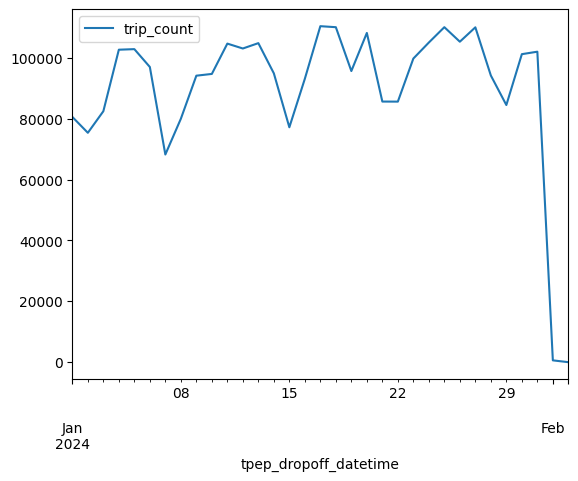

In [39]:
df.filter(pl.col("tpep_dropoff_datetime").dt.year() == 2024).sort(
    pl.col("tpep_dropoff_datetime")
).group_by_dynamic("tpep_dropoff_datetime", every="1d").agg(
    pl.len().alias("trip_count")
).to_pandas().plot.line(x="tpep_dropoff_datetime", y="trip_count")

## Data cleaning and prepreprocessing


Many operations of data cleaning, transforming, merging, deduplication etc. are done on the level of DataFrame processing. Others, like scaling or filling missing values (e.g. with mean or median) in ML, are more frequently implemented as scikit-learn pipelines. It depends on a use case, but many times we need to preprocess data as an integral part of creating the resulting dataset.

Important Polars functions related to data cleaning

- `.describe()` - summarize column statistics
- `.is_null()`, `.is_not_null()` - checking and filtering missing values
- `.drop_nulls()` - removing rows with missing values
- `.drop()` - removing columns
- `.fill_null()` - fills missing values
- `.cast()` - change column data type
- `.to_dummies()` - use one-hot encoding with dummy variables for categorical column
- `.unique()` - drops duplicate rows by a given column

As an example, let's see the date range in out data. It should be only January 2024.


In [40]:
(
    df.select(
        pl.col("tpep_pickup_datetime").min().alias("pickup_time_min"),
        pl.col("tpep_pickup_datetime").max().alias("pickup_time_max"),
        pl.col("tpep_dropoff_datetime").min().alias("dropoff_time_min"),
        pl.col("tpep_dropoff_datetime").max().alias("dropoff_time_max"),
    )
)

pickup_time_min,pickup_time_max,dropoff_time_min,dropoff_time_max
datetime[ns],datetime[ns],datetime[ns],datetime[ns]
2002-12-31 22:59:39,2024-02-01 00:01:15,2002-12-31 23:05:41,2024-02-02 13:56:52


Smallest times are from 2002, that's definitely wrong! End times slightly in February are more acceptable.

Let's also check passenger counts. NYC taxis take at most 6 passengers, larger numbers are group rides, provided in another file. This number is written manually by the taxi driver, so we also expect many missing values.


In [41]:
over_6_passengers_count = len(df.filter(pl.col("passenger_count") > 6))
null_passengers_count = len(df.filter(pl.col("passenger_count").is_null()))

over_6_passengers_perc = over_6_passengers_count / len(df)
null_passengers_perc = null_passengers_count / len(df)

print(f"Over 6 passengers: {over_6_passengers_count} ({over_6_passengers_perc:.3%})")
print(f"Null passengers: {null_passengers_count} ({null_passengers_perc:.3%})")

Over 6 passengers: 60 (0.002%)
Null passengers: 140162 (4.728%)


To check null values in all columns, `.describe()` works really well:


In [42]:
df.describe()

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.964624e6,"""2964624""","""2964624""",2.824462e6,2.964624e6,2.824462e6,"""2824462""",2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.964624e6,2.824462e6,2.824462e6
"""null_count""",0.0,"""0""","""0""",140162.0,0.0,140162.0,"""140162""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140162.0,140162.0
"""mean""",1.754204,"""2024-01-17 00:46:36.431093""","""2024-01-17 01:02:13.208130""",1.339281,3.652169,2.069359,null,166.017884,165.116712,1.161271,18.175062,1.451598,0.483382,3.33587,0.527021,0.975632,26.801505,2.256122,0.141161
"""std""",0.43259,null,null,0.850282,225.462572,9.823219,null,63.623914,69.31535,0.580869,18.949548,1.804102,0.11776,3.896551,2.12831,0.218364,23.385577,0.823275,0.487624
"""min""",1.0,"""2002-12-31 22:59:39""","""2002-12-31 23:05:41""",0.0,0.0,1.0,"""N""",1.0,1.0,0.0,-899.0,-7.5,-0.5,-80.0,-80.0,-1.0,-900.0,-2.5,-1.75
"""25%""",2.0,"""2024-01-09 15:59:20""","""2024-01-09 16:16:23""",1.0,1.0,1.0,null,132.0,114.0,1.0,8.6,0.0,0.5,1.0,0.0,1.0,15.38,2.5,0.0
"""50%""",2.0,"""2024-01-17 10:45:38""","""2024-01-17 11:03:52""",1.0,1.68,1.0,null,162.0,162.0,1.0,12.8,1.0,0.5,2.7,0.0,1.0,20.1,2.5,0.0
"""75%""",2.0,"""2024-01-24 18:23:52""","""2024-01-24 18:40:29""",1.0,3.11,1.0,null,234.0,234.0,1.0,20.5,2.5,0.5,4.12,0.0,1.0,28.56,2.5,0.0
"""max""",6.0,"""2024-02-01 00:01:15""","""2024-02-02 13:56:52""",9.0,312722.3,99.0,"""Y""",265.0,265.0,4.0,5000.0,14.25,4.0,428.0,115.92,1.0,5000.0,2.5,1.75


Note that there is exactly the same number of NULL values in all columns. This can also indicate more systematic problem and deeper real-life investigation. Here, we should probably remove that data.

If we wanted to use this data in machine learning pipelines, e.g. for forecasting number of taxi rides, the borough information could be very useful. However, it's a categorical variable, and very few algorithms support them natively (notably XGBoost, LightGBM, CatBoost). Encoding with dummy variables would be useful here.


In [43]:
df_taxi_zones

LocationID,Borough,Zone,service_zone
i64,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""
…,…,…,…
261,"""Manhattan""","""World Trade Center""","""Yellow Zone"""
262,"""Manhattan""","""Yorkville East""","""Yellow Zone"""
263,"""Manhattan""","""Yorkville West""","""Yellow Zone"""


In [44]:
(df_taxi_zones.select(["LocationID", "Borough"]).to_dummies("Borough"))

LocationID,Borough_Bronx,Borough_Brooklyn,Borough_EWR,Borough_Manhattan,Borough_N/A,Borough_Queens,Borough_Staten Island,Borough_Unknown
i64,u8,u8,u8,u8,u8,u8,u8,u8
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0
…,…,…,…,…,…,…,…,…
261,0,0,0,1,0,0,0,0
262,0,0,0,1,0,0,0,0
263,0,0,0,1,0,0,0,0


For selecting columns after dummy encoding, e.g. for grouping aggregations, you can use [regular expressions](https://regex101.com/) to [select columns](https://docs.pola.rs/api/python/version/0.18/reference/expressions/api/polars.col.html) in `pl.col()`. Regular expressions need to start with `^` and end with `$`. You can also pass such general expressions as aggregations directly.

As an example, let's compute a total number of rides from different borough for each day.


In [45]:
(
    df.join(df_taxi_zones, left_on="PULocationID", right_on="LocationID")
    .with_columns(pl.col("tpep_pickup_datetime").dt.date().alias("date"))
    .select(["date", "passenger_count", "Borough"])
    .to_dummies("Borough")
    .group_by("date")
    # select all columns with name starting with "Borough_" and anything further
    .agg(pl.col("^Borough_.*$").sum())
)

date,Borough_Bronx,Borough_Brooklyn,Borough_EWR,Borough_Manhattan,Borough_N/A,Borough_Queens,Borough_Staten Island,Borough_Unknown
date,i64,i64,i64,i64,i64,i64,i64,i64
2024-01-12,273,931,15,92299,61,9779,3,294
2002-12-31,0,0,0,2,0,0,0,0
2024-01-02,205,836,20,62923,66,11185,2,282
2024-01-07,143,430,15,57166,79,9465,2,243
2024-01-04,275,771,10,91923,49,9470,2,401
…,…,…,…,…,…,…,…,…
2024-01-09,269,843,7,85414,65,7108,5,251
2024-01-31,252,820,7,93409,24,7317,1,290
2024-01-24,268,795,5,96072,37,7648,2,293


Lastly, it's often useful to reduce the number of bits. By default, Polars is quite conservative and uses quite large integers. We can use a much smaller number in many cases, e.g. for categorical variables, small counts, or identifiers. This reduces memory usage and also speeds up calculations on modern processors, which can pack more data for vector operations this way.

Here, two functions are useful:

- `.schema()` to get column names and types
- `.describe()` to get minimal and maximal values of all columns


In [46]:
df.schema

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('RatecodeID', Int64),
        ('store_and_fwd_flag', String),
        ('PULocationID', Int32),
        ('DOLocationID', Int32),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('airport_fee', Float64)])

For example, we see that `passenger_count` could be a small unsigned integer, as it's surely under 255. See [documentation](https://docs.pola.rs/api/python/stable/reference/datatypes.html) for a list of data types.


In [47]:
df.with_columns(pl.col("passenger_count").cast(pl.UInt8))

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i32,datetime[ns],datetime[ns],u8,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-01-31 23:45:59,2024-01-31 23:54:36,null,3.18,null,null,107,263,0,15.77,0.0,0.5,2.0,0.0,1.0,21.77,null,null
1,2024-01-31 23:13:07,2024-01-31 23:27:52,null,4.0,null,null,114,236,0,18.4,1.0,0.5,2.34,0.0,1.0,25.74,null,null
2,2024-01-31 23:19:00,2024-01-31 23:38:00,null,3.33,null,null,211,25,0,19.97,0.0,0.5,0.0,0.0,1.0,23.97,null,null


**Exercises**

1. Keep only rows from 2024.
2. Check how many rows have zero passengers. Keep rows that have between 1 and 6 passengers (inclusive).
3. Remove trips lasting over two hours.
4. Check value ranges of `PULocationID` and `DOLocationID`, and optimize their data types.


1. Keeping only rows from 2024


In [48]:
df = df.filter(pl.col("tpep_dropoff_datetime").dt.year() == 2024)

2. Keeping rows that have between 1 and 6 passengers (inclusive)


In [49]:
zero_passengers = len(df.filter(pl.col("passenger_count") == 0))
print(f"{zero_passengers} rows does not contain information about passenger count")

31465 rows does not contain information about passenger count


In [50]:
df = df.filter(pl.col("passenger_count").is_between(1, 6))

3. Removing trips lasting over two hours


In [51]:
df = df.filter(
    (
        pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")
    ).dt.total_minutes()
    < 120
)

4. Optimizing data types of `PULocationID` and `DOLocationID`


In [52]:
df[["PULocationID", "DOLocationID"]].describe()

statistic,PULocationID,DOLocationID
str,f64,f64
"""count""",2.790199e6,2.790199e6
"""null_count""",0.0,0.0
"""mean""",166.214986,165.468741
"""std""",63.184948,69.189765
"""min""",1.0,1.0
"""25%""",132.0,114.0
"""50%""",162.0,162.0
"""75%""",234.0,234.0
"""max""",265.0,265.0


In [53]:
df = df.with_columns(
    pl.col("PULocationID").cast(pl.UInt16),
    pl.col("DOLocationID").cast(pl.UInt16),
)

In [54]:
df.schema

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('RatecodeID', Int64),
        ('store_and_fwd_flag', String),
        ('PULocationID', UInt16),
        ('DOLocationID', UInt16),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('airport_fee', Float64)])

## Lazy execution


We used the **eager** execution mode before. Now, let's use the **lazy** mode, which is very useful for operating on larger data. Let's read all Parquet files for 2024. Polars allows glob syntax with wildcard `*` to read many files.

Let's see what happens for eager `.read_parquet()`.


In [55]:
df = pl.read_parquet(f"{DATA_DIR}/*.parquet")

SchemaError: data type mismatch for column tpep_pickup_datetime: incoming: Datetime('μs') != target: Datetime('ns')

We have an error - some files have column `tpep_pickup_datetime` encoded as nanosecond integers, and others as microseconds. This can be fixed with manually casting this column. With eager mode, we would have to:

- read list of DataFrames
- cast every one
- concatenate them

However, this is very suboptimal, e.g. DataFrames will be read sequentially, when they could be read in parallel. So let's use the lazy API, with `.scan_parquet()` instead of `.read_parquet()`. It returns a `LazyFrame` object.


In [56]:
df = pl.scan_parquet(f"{DATA_DIR}/1.parquet")
print(type(df))
df

<class 'polars.lazyframe.frame.LazyFrame'>


No computation has happened yet - we just created a computation graph with a single operation. It's not even optimized yet. Let's build a larger graph, reading all Parquet files and casting the columns appropriately.

General type casting uses `.cast()` method. Changing time units like here uses `.dt.cast_time_unit()` instead, as this can be done much faster as a specialized function.

We will also call `.explain()` to print the computation graph.


In [57]:
dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)

df_2024 = pl.concat(dfs)
print(df_2024.explain())

UNION
  PLAN 0:
     WITH_COLUMNS:
     [col("tpep_pickup_datetime").dt.cast_time_unit(), col("tpep_dropoff_datetime").dt.cast_time_unit()] 
      Parquet SCAN [data/1.parquet]
      PROJECT */19 COLUMNS
  PLAN 1:
     WITH_COLUMNS:
     [col("tpep_pickup_datetime").dt.cast_time_unit(), col("tpep_dropoff_datetime").dt.cast_time_unit()] 
      Parquet SCAN [data/2.parquet]
      PROJECT */19 COLUMNS
  PLAN 2:
     WITH_COLUMNS:
     [col("tpep_pickup_datetime").dt.cast_time_unit(), col("tpep_dropoff_datetime").dt.cast_time_unit()] 
      Parquet SCAN [data/3.parquet]
      PROJECT */19 COLUMNS
  PLAN 3:
     WITH_COLUMNS:
     [col("tpep_pickup_datetime").dt.cast_time_unit(), col("tpep_dropoff_datetime").dt.cast_time_unit()] 
      Parquet SCAN [data/4.parquet]
      PROJECT */19 COLUMNS
  PLAN 4:
     WITH_COLUMNS:
     [col("tpep_pickup_datetime").dt.cast_time_unit(), col("tpep_dropoff_datetime").dt.cast_time_unit()] 
      Parquet SCAN [data/5.parquet]
      PROJECT */19 COLUMNS
  PL

Nothing happened yet, and nothing will happen until we call `.collect()` or a lazy output function like e.g. `.sink_parquet()` (that would use streaming mode). Let's do it then. Note that this will load the entire 2024 data into memory.


In [58]:
df_2024.collect()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
i32,datetime[ms],datetime[ms],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-12-31 23:32:00,2024-12-31 23:56:00,null,10.71,null,null,16,7,0,-4.13,0.0,0.5,0.0,0.0,1.0,-2.63,null,null
2,2024-12-31 23:05:00,2024-12-31 23:18:00,null,4.56,null,null,252,16,0,-1.68,0.0,0.5,0.0,0.0,1.0,-0.18,null,null
2,2024-12-31 23:03:16,2024-12-31 23:28:35,null,3.94,null,null,181,255,0,4.46,0.0,0.5,5.19,0.0,1.0,11.15,null,null


You can call most operations on a LazyFrame, except for the ones that require [knowledge of data schema](https://docs.pola.rs/user-guide/lazy/schemas/#the-lazy-api-must-know-the-schema). It is known only based on materialized data. This is e.g. `.to_dummies()` ([documentation](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.to_dummies.html)), which applies one-hot encoding to a categorical column. It needs to read the data and know the actual possible categories to create columns. Other examples include `.pivot()` and `.columns` attribute.

Let's see an example of a lazy query that also heavily filters the data. This will also nicely utilize the ability of Parquet to read only certain columns and rows from files.


In [59]:
# average total taxi fare from the airport among tipping customers
(
    df_2024.filter(
        pl.col("Airport_fee").is_not_null(),
        pl.col("Airport_fee") > 0,
        pl.col("tip_amount") > 0,
    )
    .select("total_amount")
    .mean()
    .collect()
)

total_amount
f64
81.109959


**Exercises**

1. Compare the speed of the above query in eager and lazy modes.
2. Using lazy execution, compare the median taxi fare in the first and fourth quarters of 2024.
3. Using lazy execution, calculate the median daily values of total amount of taxi fares. Then calculate their rolling sum with a weekly window. Plot the result on a line plot.


1. Comparison of speed of the above query in eager and lazy modes


In [60]:
from time import time

start_eager = time()
df_eager = df_2024.collect()
(
    df_eager.filter(
        pl.col("Airport_fee").is_not_null(),
        pl.col("Airport_fee") > 0,
        pl.col("tip_amount") > 0,
    )
    .select("total_amount")
    .mean()
)
end_eager = time()
print(f"Eager mode: {end_eager - start_eager:.4f} seconds")

Eager mode: 1.5925 seconds


In [61]:
start_lazy = time()
(
    df_2024.filter(
        pl.col("Airport_fee").is_not_null(),
        pl.col("Airport_fee") > 0,
        pl.col("tip_amount") > 0,
    )
    .select("total_amount")
    .mean()
    .collect()
)
end_lazy = time()
print(f"Lazy mode: {end_lazy - start_lazy:.4f} seconds")

Lazy mode: 0.1334 seconds


2. Median taxi fare in the first and fourth quarters of 2024 using lazy execution


In [62]:
df_2024.filter(
    pl.col("tpep_dropoff_datetime").dt.quarter().is_in([1, 4]),
    pl.col("tpep_dropoff_datetime").dt.year() == 2024,
).select(pl.col("fare_amount")).median().collect()

fare_amount
f64
13.5


3. Median daily values of total amount of taxi fares and their rolling sum with a weekly window using lazy execution


<Axes: xlabel='date'>

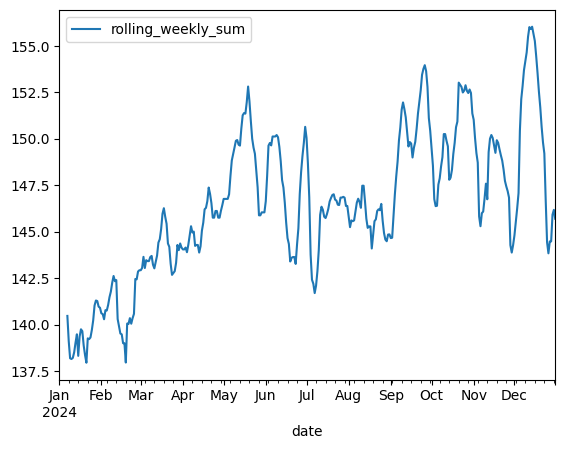

In [63]:
(
    df_2024.filter(pl.col("tpep_dropoff_datetime").dt.year() == 2024)
    .group_by(pl.col("tpep_dropoff_datetime").dt.date().alias("date"))
    .agg(pl.col("total_amount").median().alias("median_daily_total"))
    .sort("date")
    .with_columns(
        pl.col("median_daily_total")
        .rolling_sum(window_size=7)
        .alias("rolling_weekly_sum")
    )
).collect().to_pandas().plot(x="date", y="rolling_weekly_sum")